# Store Sales - Time Series Forecasting
Objective : predict sales for product families sold at Favorita stores.

train data :
| date | stores_nbr | family  | # onpromotion | # sales |

test data :
dates for the next 15 days after last date in training data.

Additional information :

stores.csv - store metadata
| store_nbr | city | state | type | cluster |

oil. csv - Daily oil price
Ecuador is an oil - dependent country.
| date | # dcoilwtico |

holidays_events.csv - holidays and events
transferred column - holiday transfer from original day to another
| date | type | locale | locale_name | description | transferred |

bridge  - day not normally scheduled for work / that's meant to payback
regular calendar holiday - example, Christmas

Wages in the public sector are paid every two weeks (15 th and last day of the month)

earthquake at April 16 - 2016 - water and other first need products was donating and affected supermarket sales.

transactions
| date | store_nbr | # transactions |

In [46]:
# Required libraries
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

# Importing data

In [47]:
# train dataset
train_data = pd.read_csv("resources/challenge_03/train.csv")
train_data.info()
train_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   date         object 
 2   store_nbr    int64  
 3   family       object 
 4   sales        float64
 5   onpromotion  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 137.4+ MB


,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [48]:
# test dataset
test_data = pd.read_csv("resources/challenge_03/test.csv")
test_data.head()

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0


In [49]:
# available stores
stores = pd.read_csv("resources/challenge_03/stores.csv")
stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [50]:
# oil time series
oil = pd.read_csv("resources/challenge_03/oil.csv")
oil.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


In [51]:
# holidays events
holidays = pd.read_csv("resources/challenge_03/holidays_events.csv")
holidays.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [52]:
# transactions - IS CREATED FROM train_data grouping by date, store_nbr and sum transactions
transactions = pd.read_csv("resources/challenge_03/transactions.csv")
transactions.head()

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


# Exploratory Data Analysis

# 1. Train - Test datasets
First step, is to visualize train - test dataset to clarify the information and cross with complementary information

In [53]:
# First, we are going to know available stores, and total transactions for every store
stores_unique = list(stores.store_nbr.unique())
stores_unique

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54]

<AxesSubplot:xlabel='store_nbr', ylabel='transactions'>

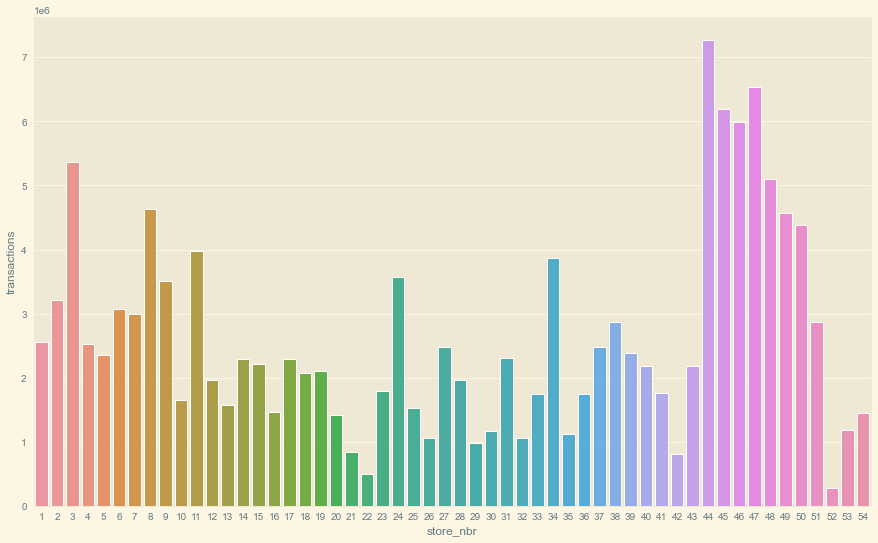

In [54]:
stores_unique_trans = transactions.groupby("store_nbr")["transactions"].sum().reset_index()
plt.style.use("Solarize_Light2")
plt.figure(figsize=(15, 9))
sns.barplot(x="store_nbr", y="transactions", data=stores_unique_trans)

<AxesSubplot:xlabel='store_nbr', ylabel='transactions'>

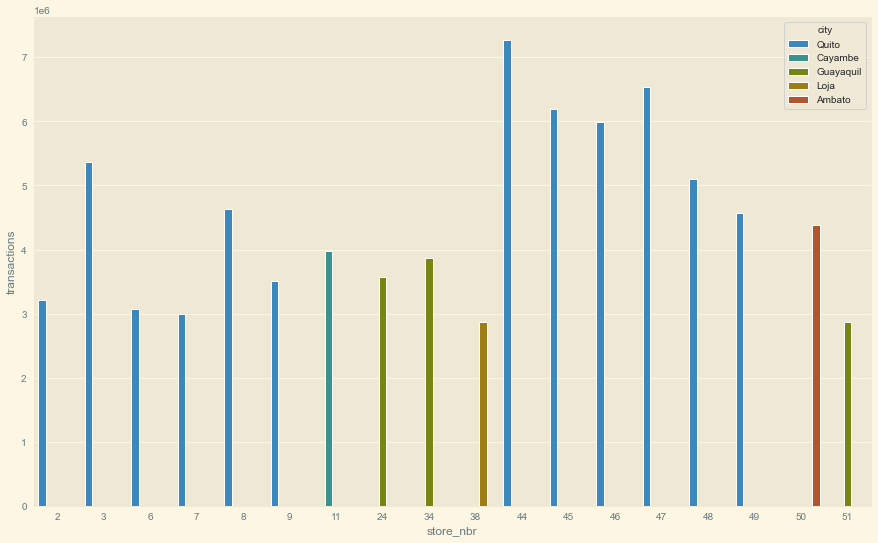

In [55]:
# Here, we can see that exist a range of specify stores where transactions are higher, so is good idea filter stores that are greater than mean value and contrast with location
stores_unique_trans_stores = stores_unique_trans.merge(stores, how="left", left_on="store_nbr", right_on="store_nbr")
transactions_greater_avg = stores_unique_trans_stores[stores_unique_trans_stores.transactions > stores_unique_trans_stores.transactions.mean()]
plt.figure(figsize=(15, 9))
sns.barplot(x="store_nbr", y="transactions", hue="city", data=transactions_greater_avg)

In [56]:
# So, here is evident that the majority of sales are from stores into main cities, such as Quito.

In [57]:
# Next step, is to visualize available product families into train - test datasets
train_product_f = list(train_data["family"].unique())
test_product_f = list(test_data["family"].unique())
train_test_f_diff = train_product_f == test_product_f
print("Is %s that both datasets have rows for all product families" % train_test_f_diff)
print("%s total number of product families" % len(train_product_f))

Is True that both datasets have rows for all product families
33 total number of product families


In [58]:
# Now, is interesting visualize if "onpromotion" column is associated with dates with the highest sales.
# for this purpose, we are going to select the most popular store and analyze correlation between "onpromotion" and "sales".

onpromotion_sales = train_data[["onpromotion", "sales"]]
onpromotion_sales_corr = onpromotion_sales.corr()
print(onpromotion_sales_corr)

             onpromotion     sales
onpromotion     1.000000  0.427923
sales           0.427923  1.000000


In [59]:
# probably it's very widespread conclude that on promotion products affect sales for all stores, so is good idea select one store and analyze time series, predominant products, onpromotion influence and relation with additional information

# 2. Analyze time series for one store

In [60]:
# Now we are going to create new columns for day, month to use into next analysis
train_data['date'] =  pd.to_datetime(train_data['date'])
train_data["month"] = train_data.apply(lambda x: x.date.month, axis=1)
train_data["day"] = train_data.apply(lambda x: x.date.day, axis=1)
train_data

,id,date,store_nbr,family,sales,onpromotion,month,day
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0,1,1
1,1,2013-01-01,1,BABY CARE,0.000,0,1,1
2,2,2013-01-01,1,BEAUTY,0.000,0,1,1
3,3,2013-01-01,1,BEVERAGES,0.000,0,1,1
4,4,2013-01-01,1,BOOKS,0.000,0,1,1
...,...,...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,POULTRY,438.133,0,8,15
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1,8,15
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148,8,15
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8,8,15


In [61]:
store_nbr = 44
selected_store = stores[stores.store_nbr == store_nbr]
print("%s store number correspond to store located into state %s and city %s" % (store_nbr, selected_store.state.tolist()[0], selected_store.city.tolist()[0]))

44 store number correspond to store located into state Pichincha and city Quito


In [62]:
train_data_44 = train_data[train_data["store_nbr"] == store_nbr]
train_data_44

,id,date,store_nbr,family,sales,onpromotion,month,day
1254,1254,2013-01-01,44,AUTOMOTIVE,0.000,0,1,1
1255,1255,2013-01-01,44,BABY CARE,0.000,0,1,1
1256,1256,2013-01-01,44,BEAUTY,0.000,0,1,1
1257,1257,2013-01-01,44,BEVERAGES,0.000,0,1,1
1258,1258,2013-01-01,44,BOOKS,0.000,0,1,1
...,...,...,...,...,...,...,...,...
3000388,3000388,2017-08-15,44,POULTRY,909.194,0,8,15
3000389,3000389,2017-08-15,44,PREPARED FOODS,329.522,0,8,15
3000390,3000390,2017-08-15,44,PRODUCE,7239.617,10,8,15
3000391,3000391,2017-08-15,44,SCHOOL AND OFFICE SUPPLIES,345.000,12,8,15


In [63]:
onpromotion_sales_44 = train_data_44[["onpromotion", "sales"]]
onpromotion_sales_corr_44 = onpromotion_sales_44.corr()
(onpromotion_sales_corr_44.iloc[0, 1])


0.4895243112296241

In [64]:
# 1. Here, we can see that sales have better response to onpromotion, however is neccesary calculate correlation for every store to checkout the best store in terms of promotions.
onpromotion_sales_corr_stores = []

for store in stores_unique:
    onpromotion_sales_store = train_data[train_data["store_nbr"] == store][["onpromotion", "sales"]]
    onpromotion_sales_corr_store = onpromotion_sales_store.corr()
    onpromotion_sales_corr_stores.append(onpromotion_sales_corr_store.iloc[0, 1])

onpromotion_sales_corr_stores

[0.5236450053307483,
 0.3935404916261976,
 0.4898966542964507,
 0.47594098852749583,
 0.44890403751265084,
 0.482519550519143,
 0.5051656792608191,
 0.4864027156665383,
 0.4286002655425821,
 0.44547835319853074,
 0.45665336961354014,
 0.43656781230138797,
 0.4320910305577119,
 0.4294060175443526,
 0.44365834968180495,
 0.3335183696381142,
 0.4671146227030709,
 0.4274566520515183,
 0.4236386298157928,
 0.4848992207667649,
 0.577805536747269,
 0.6340400274237343,
 0.4243778442305249,
 0.5116486393658798,
 0.42850464615904466,
 0.39674358227616924,
 0.4908571961488586,
 0.4981044974746966,
 0.5899756950329373,
 0.47754693843087065,
 0.4560868611997658,
 0.46132690349580147,
 0.43953864942149035,
 0.4191422716955677,
 0.3938359937102097,
 0.48792752102004283,
 0.49230976074120186,
 0.47298493698771876,
 0.43240018583868184,
 0.4928211740915534,
 0.5075420348065066,
 0.6156501277662115,
 0.4208974684337469,
 0.4895243112296241,
 0.4854806900878632,
 0.44763107964369586,
 0.4911274869971194,

<AxesSubplot:xlabel='store_nbr', ylabel='store_onpromotion_corr'>

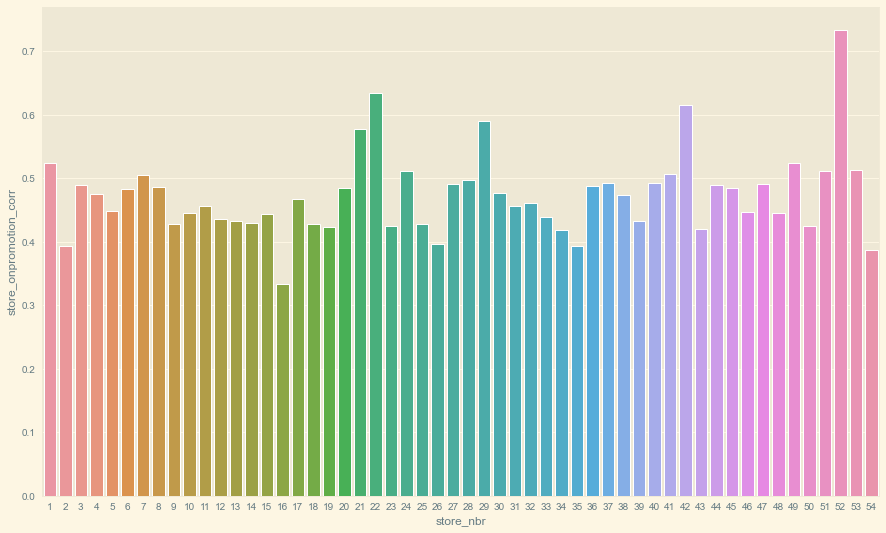

In [65]:
# Assembly store_nbr - correlation into df to create bar plot
store_corr = pd.DataFrame(columns=["store_nbr", "store_onpromotion_corr"])
store_corr["store_nbr"] = stores_unique
store_corr["store_onpromotion_corr"] = onpromotion_sales_corr_stores

plt.figure(figsize=(15, 9))
sns.barplot(x="store_nbr", y="store_onpromotion_corr", data=store_corr)

In [66]:
# Here, it can be seen that exist a good correlation range between sales an onpromotion, so is a good validation to use column as feature for prediction.

<AxesSubplot:xlabel='month', ylabel='sales'>

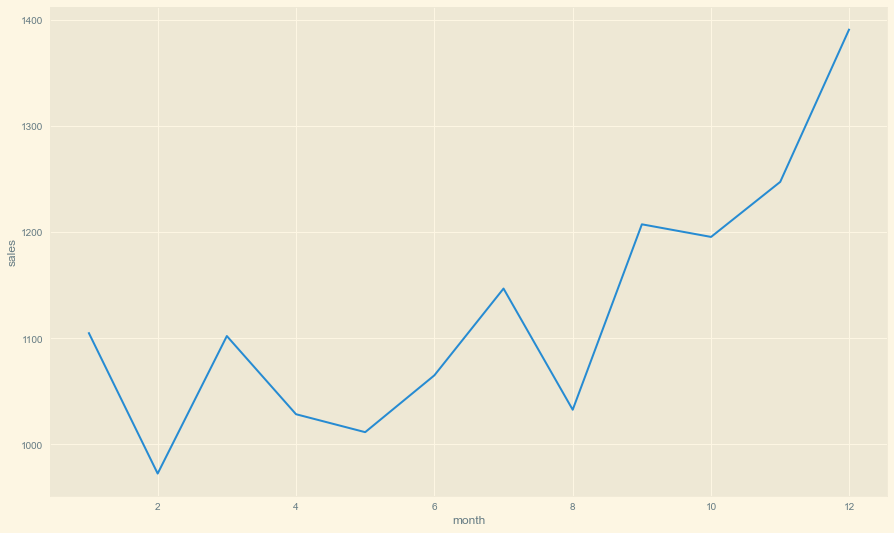

In [68]:
# Now, we can check out sale time series for current store (annual cycle)
train_data_44_month = train_data_44.groupby("month")["sales"].mean().reset_index()
plt.figure(figsize=(15, 9))
sns.lineplot(x="month", y="sales", data=train_data_44_month)

In [ ]:
# Here, we can see that relationship between months and sales for current store.

In [ ]:
# Now, we can go to check out if oil price influence store sales for current store.
